In [556]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error

import seaborn as sns


In [557]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [558]:
train.shape

(1285000, 14)

In [559]:
train.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,9.960940,1.491492,1.199018,-0.063145,0.595242,1.018416,1.248499,0.674080,-0.034194,-2.509908,-2.447517,-0.610936,-0.561048,255
256,10.000000,1.485476,1.222565,-0.250131,0.609230,1.048258,1.246830,0.859066,-0.050144,-2.533734,-2.469395,-0.608935,-0.559086,256
257,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176502,0.555739,0.000000,0.000000,-0.823498,-0.555739,0.000000,0.000000,257
258,0.039062,0.999392,0.000131,-0.031160,0.006723,-0.176326,0.555148,0.008985,-0.030279,-0.823065,-0.555279,0.022176,0.023556,258


REMOVAL OF TRAJECTORIES WITH ONLY ZEROS AND ZEROS AFTER COLLISION

In [561]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [562]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

# convert trajectory indices into row indices
row_indices = [i * 257 for i in traj_zero]

print("Trajectories starting with zeros:", traj_zero)
print("Corresponding starting rows:", row_indices)

Trajectories starting with zeros: [1050, 4058]
Corresponding starting rows: [269850, 1042906]


In [563]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [564]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)

In [565]:
def remove_collision(df, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end]

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero = zero_mask.argmax() + start
            traj = traj.loc[start:first_zero-1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [566]:
train_cleaned = remove_collision(train_cleaned)

CHECK ANOMALIES ON THE DATABASE TRAIN_CLEANED

In [568]:
def check_dataset_anomalies(df):
    print("Dataset anomalies check\n")

    # 1. Check for missing values (NaN)
    missing = df.isnull().sum().sum()
    if missing == 0:
        print("No missing values (NaN) found.")
    else:
        print(f"Found {missing} missing values (NaN).")
        print(df.isnull().sum()[df.isnull().sum() > 0])

    # 2. Check for infinite values
    inf_mask = df.isin([np.inf, -np.inf])
    inf_count = inf_mask.sum().sum()
    if inf_count == 0:
        print("No infinite values (+inf, -inf) found.")
    else:
        print(f"Found {inf_count} infinite values.")
        print(inf_mask.sum()[inf_mask.sum() > 0])

    # 3. Check for empty columns
    empty_cols = [col for col in df.columns if df[col].isnull().all()]
    if not empty_cols:
        print("No empty columns.")
    else:
        print(f"Found empty columns: {empty_cols}")


In [569]:
check_dataset_anomalies(train_cleaned)

Dataset anomalies check

No missing values (NaN) found.
No infinite values (+inf, -inf) found.
No empty columns.


CHECK THE STATISTICS OF THE DATASET

In [571]:
def dataset_summary(df):
    # --- Dimensions ---
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")

    # --- Basic statistics ---
    print("Basic statistics per column:")
    desc = df.describe().T
    print(desc[['min', 'mean', 'max']])

    # --- Standard deviation ---
    desc['std'] = df.std()
    print("\nStandard deviation:")
    print(desc['std'])

    # --- Group columns ---
    coord_cols = [col for col in df.columns if col.startswith(('x_', 'y_'))]
    vel_cols = [col for col in df.columns if col.startswith(('v_x', 'v_y'))]

    # --- Boxplots (valeurs absolues en log, comme avant) ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Coordinates
    data_coord = [np.abs(df[c]) + 1e-8 for c in coord_cols]
    axes[0].boxplot(data_coord, tick_labels=coord_cols)
    axes[0].set_yscale('log')
    axes[0].set_title("Coordinates (x, y) - log scale (abs values)")
    axes[0].set_xlabel("Variables")
    axes[0].set_ylabel("Values (log scale)")

    # Velocities
    data_vel = [np.abs(df[c]) + 1e-8 for c in vel_cols]
    axes[1].boxplot(data_vel, tick_labels=vel_cols)
    axes[1].set_yscale('log')
    axes[1].set_title("Velocities (v_x, v_y) - log scale (abs values)")
    axes[1].set_xlabel("Variables")
    axes[1].set_ylabel("Values (log scale)")

    plt.tight_layout()
    plt.show()

    # --- Histogrammes simples (pas de log) ---
    def plot_raw_hist(df, cols, color, group_name):
        for col in cols:
            plt.figure(figsize=(6, 3))
            plt.hist(df[col], bins=50, color=color, edgecolor='black')
            plt.title(f"{col} - Raw distribution ({group_name})")
            plt.xlabel("Value")
            plt.ylabel("Frequency")
    
            # ➕ Afficher min et max
            min_val = df[col].min()
            max_val = df[col].max()
            plt.annotate(f"min: {min_val:.2e}", xy=(0.98, 0.95), xycoords='axes fraction',
                         ha='right', va='top', fontsize=9, color='red')
            plt.annotate(f"max: {max_val:.2e}", xy=(0.98, 0.88), xycoords='axes fraction',
                         ha='right', va='top', fontsize=9, color='red')
    
            plt.tight_layout()
            plt.show()


    # Coordinates
    plot_raw_hist(df, coord_cols, color='skyblue', group_name='Coordinates')

    # Velocities
    plot_raw_hist(df, vel_cols, color='lightcoral', group_name='Velocities')

Shape: 1089790 rows, 13 columns

Basic statistics per column:
             min      mean        max
t       0.000000  4.887787  10.000000
x_1   -30.823004 -0.331674  16.340610
y_1   -17.857729 -0.129133  26.276226
v_x_1 -72.993333 -0.217109  23.503455
v_y_1 -23.109278 -0.019456  34.671679
x_2   -30.833398  0.008456  15.506957
y_2   -52.450808 -0.096702  35.679463
v_x_2 -25.895550  0.038295  72.718229
v_y_2 -48.289007 -0.098585  23.118346
x_3   -17.439994  0.323218  61.656402
y_3   -33.159997  0.225835  27.735539
v_x_3 -30.970540  0.178814  25.964992
v_y_3 -25.509384  0.118041  48.288738

Standard deviation:
t        2.918751
x_1      1.836845
y_1      1.266963
v_x_1    0.949104
v_y_1    0.875636
x_2      1.154264
y_2      1.127168
v_x_2    1.016519
v_y_2    1.058225
x_3      1.562294
y_3      1.825727
v_x_3    0.852717
v_y_3    0.944614
Name: std, dtype: float64


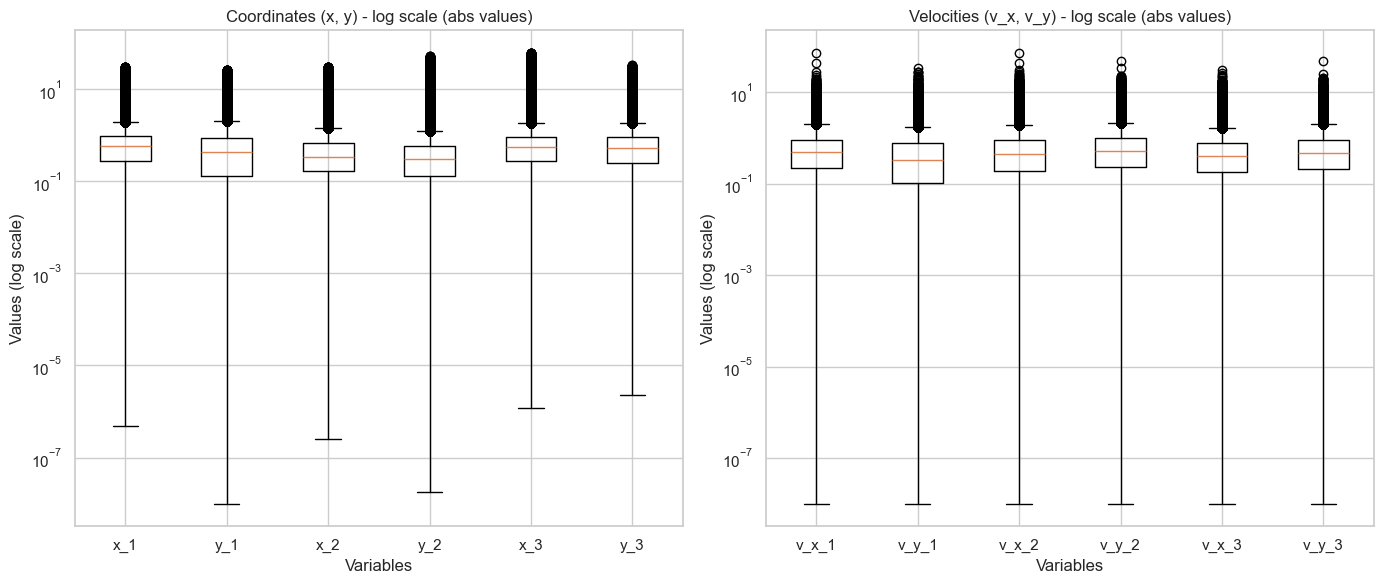

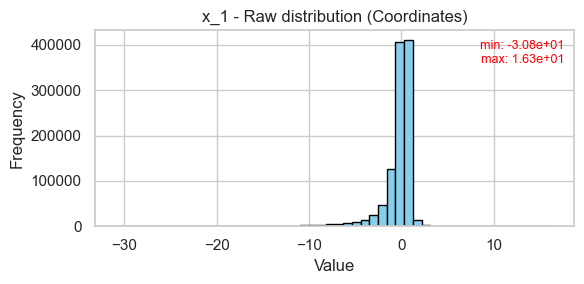

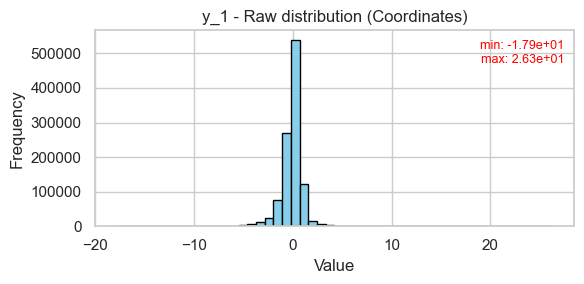

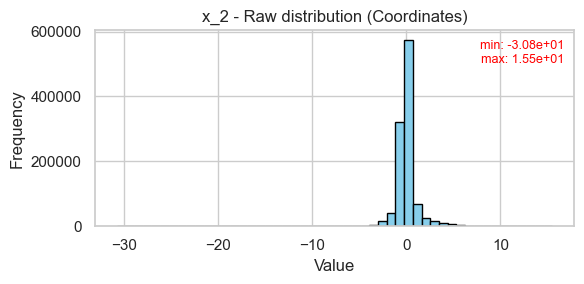

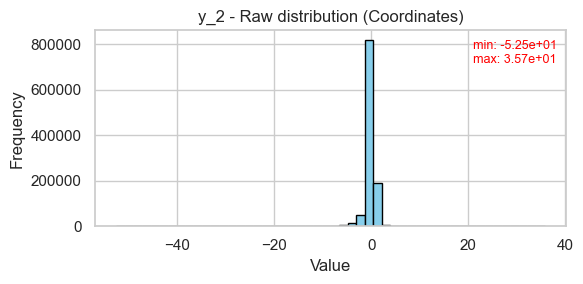

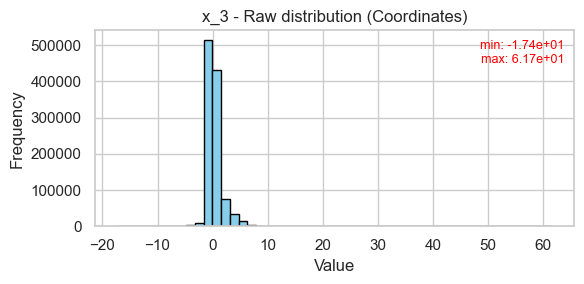

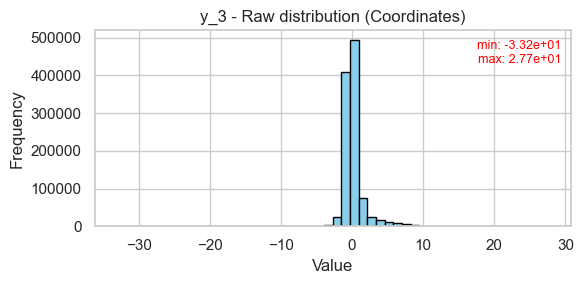

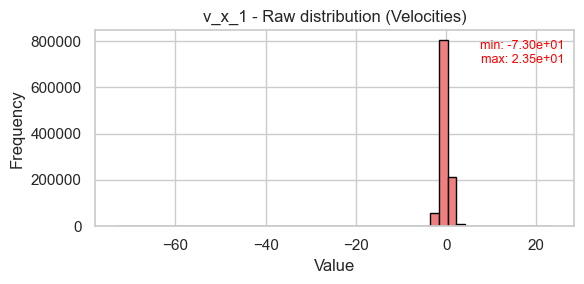

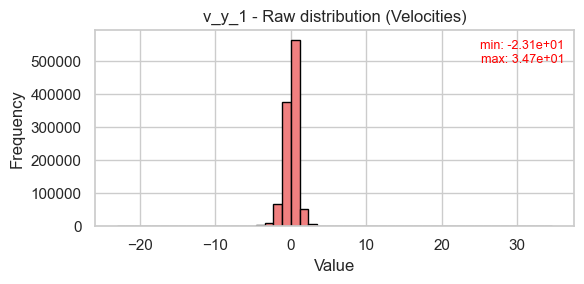

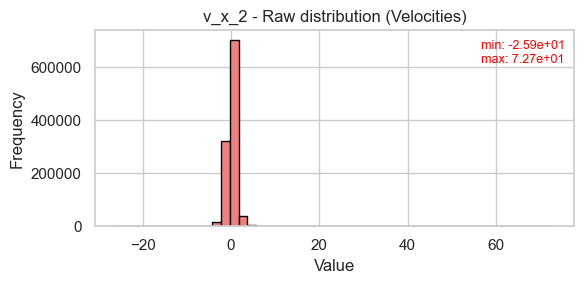

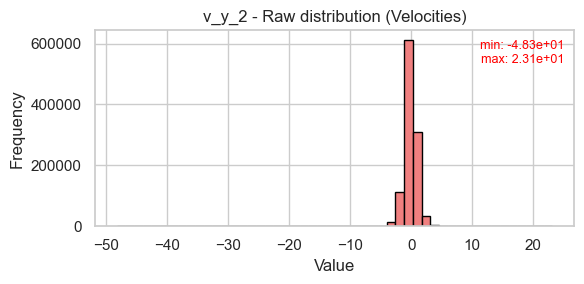

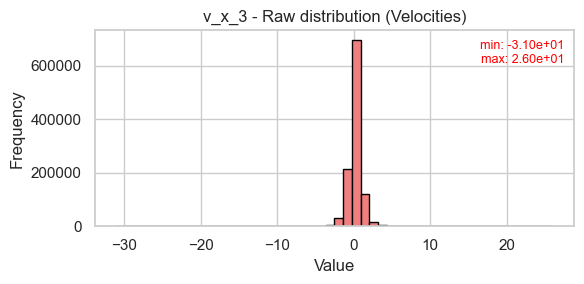

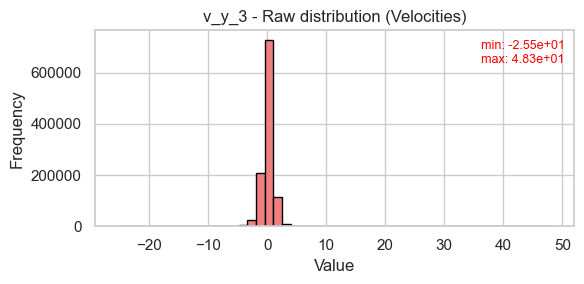

In [572]:
train_cleaned_no_id = train_cleaned.iloc[:, :-1]
dataset_summary(train_cleaned_no_id)

SPLIT INTO TRAIN, VALIDATION, AND TEST SETS (random)

In [574]:
def split_trajectories(df, 
                                train_size=0.6, 
                                validation_size=0.2, 
                                test_size=0.2, 
                                method="random", 
                                random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    # Identifier les indices de début de trajectoire
    traj_start_indices = df.index[df['t'] == 0].tolist()
    traj_start_indices.append(len(df))  # ajouter la fin pour le dernier bloc

    # Construire les slices de trajectoires
    traj_slices = [(traj_start_indices[i], traj_start_indices[i+1]) for i in range(len(traj_start_indices)-1)]
    
    if method == "random":
        np.random.shuffle(traj_slices)
    else:
        raise NotImplementedError(f"Méthode {method} non implémentée pour l'instant")

    n_traj = len(traj_slices)
    n_train = int(train_size * n_traj)
    n_val = int(validation_size * n_traj)
    n_test = int(test_size * n_traj)

    # Ajustement si reste
    n_remaining = n_traj - (n_train + n_val + n_test)
    n_train += n_remaining

    train_slices = traj_slices[:n_train]
    val_slices = traj_slices[n_train:n_train+n_val]
    test_slices = traj_slices[n_train+n_val:n_train+n_val+n_test]

    # Concaténer les DataFrames correspondants
    train_df = pd.concat([df.iloc[start:end] for start, end in train_slices])
    val_df = pd.concat([df.iloc[start:end] for start, end in val_slices])
    test_df = pd.concat([df.iloc[start:end] for start, end in test_slices])

    return train_df, val_df, test_df


In [575]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [576]:
print(train_after_split.shape)
print(validation_after_split.shape)
print(test_after_split.shape)

(653206, 14)
(219169, 14)
(217415, 14)


In [577]:
# VERIFY THAT TRAIN, VALIDATION, AND TEST SETS HAVE NO OVERLAP
train_ids = set(train_after_split['Id'].unique())
val_ids = set(validation_after_split['Id'].unique())
test_ids = set(test_after_split['Id'].unique())

print("Train ∩ Validation :", train_ids & val_ids)
print("Train ∩ Test :", train_ids & test_ids)
print("Validation ∩ Test :", val_ids & test_ids)

Train ∩ Validation : set()
Train ∩ Test : set()
Validation ∩ Test : set()


In [578]:
train_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
146813,0.000000,1.000000,0.000000,0.000000,0.000000,-0.202110,0.383120,0.000000,0.000000,-0.797890,-0.383120,0.000000,0.000000,171676
146814,0.039062,0.999322,0.000098,-0.034705,0.005041,-0.202150,0.382335,-0.002091,-0.040219,-0.797172,-0.382434,0.036796,0.035178,171677
146815,0.078125,0.997287,0.000394,-0.069519,0.010074,-0.202275,0.379976,-0.004302,-0.080639,-0.795013,-0.380369,0.073822,0.070565,171678
146816,0.117188,0.993888,0.000885,-0.104556,0.015091,-0.202490,0.376030,-0.006761,-0.121469,-0.791398,-0.376915,0.111317,0.106378,171679
146817,0.156250,0.989114,0.001572,-0.139931,0.020083,-0.202808,0.370478,-0.009608,-0.162932,-0.786306,-0.372050,0.149539,0.142850,171680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147068,9.960940,-5.359348,-4.097365,1.407672,-3.137157,-5.324242,-4.131776,-3.730040,1.347726,10.683590,8.229141,2.322368,1.789431,171931
147069,10.000000,-5.429888,-4.112360,-0.858343,-1.044710,-5.344417,-4.186678,-1.463875,-0.744606,10.774304,8.299038,2.322218,1.789315,171932
285505,0.000000,1.000000,0.000000,0.000000,0.000000,-0.094913,0.310974,0.000000,0.000000,-0.905087,-0.310974,0.000000,0.000000,335642
285506,0.039062,0.999231,0.000128,-0.039374,0.006548,-0.094927,0.310367,-0.000709,-0.031055,-0.904304,-0.310495,0.040082,0.024507,335643


In [579]:
validation_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
716999,0.000000,1.000000,0.000000,0.000000,0.000000,-0.135413,0.238102,0.000000,0.000000,-0.864587,-0.238102,0.000000,0.000000,843217
717000,0.039062,0.999231,0.000089,-0.039391,0.004553,-0.135701,0.237436,-0.014766,-0.034149,-0.863530,-0.237525,0.054158,0.029596,843218
717001,0.078125,0.996921,0.000355,-0.078895,0.009085,-0.136571,0.235432,-0.029846,-0.068484,-0.860350,-0.235787,0.108741,0.059400,843219
717002,0.117188,0.993064,0.000798,-0.118624,0.013573,-0.138041,0.232080,-0.045572,-0.103201,-0.855023,-0.232879,0.164197,0.089628,843220
717003,0.156250,0.987649,0.001415,-0.158695,0.017994,-0.140144,0.227362,-0.062315,-0.138511,-0.847505,-0.228777,0.221011,0.120517,843221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717254,9.960940,-0.206839,0.910150,-0.071281,0.115052,-0.172580,0.211632,0.149520,-0.220985,0.379419,-1.121782,-0.078238,0.105932,843472
717255,10.000000,-0.209495,0.912940,-0.064568,0.028214,-0.166680,0.204199,0.152454,-0.160061,0.376175,-1.117139,-0.087887,0.131848,843473
145663,0.000000,1.000000,0.000000,0.000000,0.000000,-0.447619,0.436155,0.000000,0.000000,-0.552381,-0.436155,0.000000,0.000000,170134
145664,0.039062,0.999398,0.000017,-0.030843,0.000866,-0.447417,0.435077,0.010326,-0.055256,-0.551981,-0.435094,0.020517,0.054390,170135


In [580]:
test_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
421510,0.000000,1.000000,0.000000,0.000000,0.000000,-0.111410,0.919617,0.000000,0.000000,-0.888590,-0.919617,0.000000,0.000000,492155
421511,0.039062,0.999562,0.000158,-0.022429,0.008095,-0.111202,0.919207,0.010654,-0.020999,-0.888360,-0.919365,0.011776,0.012904,492156
421512,0.078125,0.998247,0.000633,-0.044903,0.016212,-0.110577,0.917976,0.021335,-0.042036,-0.887670,-0.918609,0.023567,0.025824,492157
421513,0.117188,0.996053,0.001425,-0.067464,0.024372,-0.109534,0.915922,0.032074,-0.063150,-0.886519,-0.917347,0.035390,0.038778,492158
421514,0.156250,0.992975,0.002538,-0.090160,0.032599,-0.108070,0.913041,0.042898,-0.084381,-0.884905,-0.915579,0.047262,0.051782,492159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421765,9.960940,-0.246809,-0.236008,-1.667775,-0.351526,0.002588,0.096040,0.325341,-1.821544,0.244220,0.139969,1.342434,2.173071,492410
421766,10.000000,-0.307692,-0.245404,-1.448855,-0.140318,0.022294,0.025097,0.620588,-1.787814,0.285398,0.220306,0.828267,1.928132,492411
398593,0.000000,1.000000,0.000000,0.000000,0.000000,-0.478880,0.350652,0.000000,0.000000,-0.521120,-0.350652,0.000000,0.000000,465941
398594,0.039062,0.999373,0.000006,-0.032094,0.000300,-0.478652,0.349031,0.011690,-0.083135,-0.520722,-0.349037,0.020404,0.082835,465942


CREATION OF INPUT VECTOR WITH INITIAL POSITION AND TIMES

In [582]:
def replicate_initial_position_by_block(df):
    coords = ["x_1", "y_1",
              "x_2", "y_2",
              "x_3", "y_3"]
    
    copy = df.copy()
    data = copy[coords].values
    t_values = copy["t"].values
    
    # Détecter le début des blocs
    block_starts = np.where(t_values == 0)[0]
    block_starts = np.append(block_starts, len(df))  # ajouter fin du dernier bloc
    
    # Répliquer la position initiale pour chaque bloc
    for i in range(len(block_starts) - 1):
        start, end = block_starts[i], block_starts[i + 1]
        data[start:end] = data[start]  # réplication vectorisée
        
    
    copy[coords] = data
    return copy


In [583]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

In [584]:
train_entry.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
146813,0.000000,1.0,0.0,0.000000,0.000000,-0.202110,0.383120,0.000000,0.000000,-0.797890,-0.383120,0.000000,0.000000,171676
146814,0.039062,1.0,0.0,-0.034705,0.005041,-0.202110,0.383120,-0.002091,-0.040219,-0.797890,-0.383120,0.036796,0.035178,171677
146815,0.078125,1.0,0.0,-0.069519,0.010074,-0.202110,0.383120,-0.004302,-0.080639,-0.797890,-0.383120,0.073822,0.070565,171678
146816,0.117188,1.0,0.0,-0.104556,0.015091,-0.202110,0.383120,-0.006761,-0.121469,-0.797890,-0.383120,0.111317,0.106378,171679
146817,0.156250,1.0,0.0,-0.139931,0.020083,-0.202110,0.383120,-0.009608,-0.162932,-0.797890,-0.383120,0.149539,0.142850,171680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147068,9.960940,1.0,0.0,1.407672,-3.137157,-0.202110,0.383120,-3.730040,1.347726,-0.797890,-0.383120,2.322368,1.789431,171931
147069,10.000000,1.0,0.0,-0.858343,-1.044710,-0.202110,0.383120,-1.463875,-0.744606,-0.797890,-0.383120,2.322218,1.789315,171932
285505,0.000000,1.0,0.0,0.000000,0.000000,-0.094913,0.310974,0.000000,0.000000,-0.905087,-0.310974,0.000000,0.000000,335642
285506,0.039062,1.0,0.0,-0.039374,0.006548,-0.094913,0.310974,-0.000709,-0.031055,-0.905087,-0.310974,0.040082,0.024507,335643


In [585]:
validation_entry.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
716999,0.000000,1.0,0.0,0.000000,0.000000,-0.135413,0.238102,0.000000,0.000000,-0.864587,-0.238102,0.000000,0.000000,843217
717000,0.039062,1.0,0.0,-0.039391,0.004553,-0.135413,0.238102,-0.014766,-0.034149,-0.864587,-0.238102,0.054158,0.029596,843218
717001,0.078125,1.0,0.0,-0.078895,0.009085,-0.135413,0.238102,-0.029846,-0.068484,-0.864587,-0.238102,0.108741,0.059400,843219
717002,0.117188,1.0,0.0,-0.118624,0.013573,-0.135413,0.238102,-0.045572,-0.103201,-0.864587,-0.238102,0.164197,0.089628,843220
717003,0.156250,1.0,0.0,-0.158695,0.017994,-0.135413,0.238102,-0.062315,-0.138511,-0.864587,-0.238102,0.221011,0.120517,843221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717254,9.960940,1.0,0.0,-0.071281,0.115052,-0.135413,0.238102,0.149520,-0.220985,-0.864587,-0.238102,-0.078238,0.105932,843472
717255,10.000000,1.0,0.0,-0.064568,0.028214,-0.135413,0.238102,0.152454,-0.160061,-0.864587,-0.238102,-0.087887,0.131848,843473
145663,0.000000,1.0,0.0,0.000000,0.000000,-0.447619,0.436155,0.000000,0.000000,-0.552381,-0.436155,0.000000,0.000000,170134
145664,0.039062,1.0,0.0,-0.030843,0.000866,-0.447619,0.436155,0.010326,-0.055256,-0.552381,-0.436155,0.020517,0.054390,170135


In [586]:
test_entry.head(50)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
421510,0.000000,1.0,0.0,0.000000,0.000000,-0.11141,0.919617,0.000000,0.000000,-0.88859,-0.919617,0.000000,0.000000,492155
421511,0.039062,1.0,0.0,-0.022429,0.008095,-0.11141,0.919617,0.010654,-0.020999,-0.88859,-0.919617,0.011776,0.012904,492156
421512,0.078125,1.0,0.0,-0.044903,0.016212,-0.11141,0.919617,0.021335,-0.042036,-0.88859,-0.919617,0.023567,0.025824,492157
421513,0.117188,1.0,0.0,-0.067464,0.024372,-0.11141,0.919617,0.032074,-0.063150,-0.88859,-0.919617,0.035390,0.038778,492158
421514,0.156250,1.0,0.0,-0.090160,0.032599,-0.11141,0.919617,0.042898,-0.084381,-0.88859,-0.919617,0.047262,0.051782,492159
421515,0.195312,1.0,0.0,-0.113037,0.040916,-0.11141,0.919617,0.053839,-0.105770,-0.88859,-0.919617,0.059198,0.064853,492160
421516,0.234375,1.0,0.0,-0.136145,0.049349,-0.11141,0.919617,0.064929,-0.127359,-0.88859,-0.919617,0.071215,0.078010,492161
421517,0.273438,1.0,0.0,-0.159535,0.057923,-0.11141,0.919617,0.076203,-0.149194,-0.88859,-0.919617,0.083332,0.091271,492162
421518,0.312500,1.0,0.0,-0.183264,0.066668,-0.11141,0.919617,0.087697,-0.171323,-0.88859,-0.919617,0.095567,0.104655,492163
421519,0.351562,1.0,0.0,-0.207392,0.075616,-0.11141,0.919617,0.099453,-0.193798,-0.88859,-0.919617,0.107939,0.118182,492164


In [587]:
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

pipeline.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

COEFFICIENT VISUALIZATION


Coefficients pour x_1 :
  t: -0.541215293584899
  x_1: 88284.66536462164
  y_1: 113045.4627097969
  x_2: -156782169858.55685
  y_2: -25808868259.086277
  x_3: -156782169859.0618
  y_3: -25808868258.80794
Intercept: -0.31885025785173315

Coefficients pour y_1 :
  t: -0.059588027147668345
  x_1: -39171.87581270823
  y_1: -50158.523765463375
  x_2: 64662419385.768684
  y_2: 11478011190.167772
  x_3: 64662419385.70276
  y_3: 11478011190.430803
Intercept: -0.13865604743133098

Coefficients pour x_2 :
  t: 0.06221850277726169
  x_1: -42275.47334980333
  y_1: -54133.79026191669
  x_2: 49648451391.09695
  y_2: 12496796882.967386
  x_3: 49648451391.178604
  y_3: 12496796883.034956
Intercept: -0.011564125926300945

Coefficients pour y_2 :
  t: -0.2503685708782546
  x_1: 2781.940717082139
  y_1: 3561.06661844096
  x_2: -23698937633.4749
  y_2: -711372322.6812729
  x_3: -23698937633.59577
  y_3: -711372322.6112
Intercept: -0.09577847448121828

Coefficients pour x_3 :
  t: 0.4789967908120545
  x_1

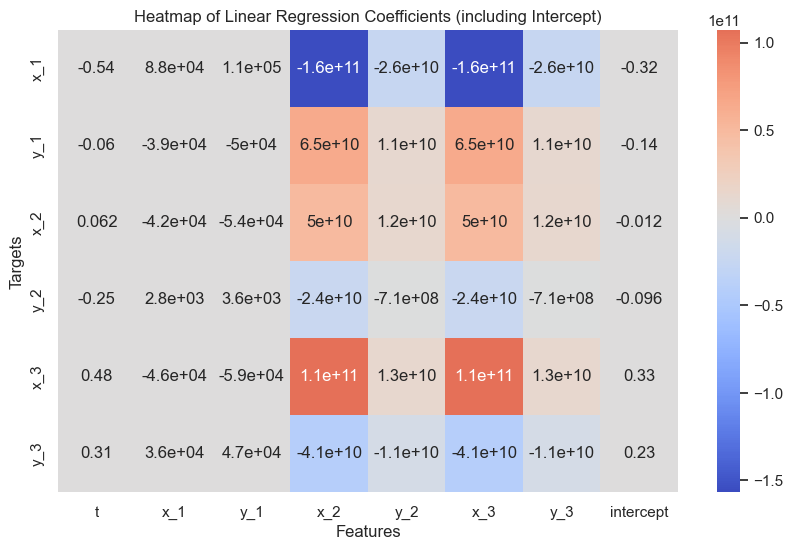

In [589]:
coefficients = pipeline.named_steps['linearregression'].coef_  # shape = (n_targets, n_features)
intercepts = pipeline.named_steps['linearregression'].intercept_  # shape = (n_targets,)

# Afficher les coefficients pour chaque target
for i, target in enumerate(target_cols):
    print(f"\nCoefficients pour {target} :")
    for col, coef in zip(input_cols, coefficients[i]):
        print(f"  {col}: {coef}")
    print(f"Intercept: {intercepts[i]}")

# Créer un DataFrame pour les coefficients et ajouter l'intercept
coef_df = pd.DataFrame(coefficients, index=target_cols, columns=input_cols)
coef_df['intercept'] = intercepts  # ajouter l'intercept comme dernière colonne

plt.figure(figsize=(10, 6))
sns.heatmap(coef_df, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap of Linear Regression Coefficients (including Intercept)")
plt.xlabel("Features")
plt.ylabel("Targets")
plt.show()

ERROR VISUALIZATION

In [591]:
X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

y_pred_val = pipeline.predict(X_val) 

X_test = test_entry[input_cols]
y_test= test_after_split[target_cols]

y_pred_test = pipeline.predict(X_test) 


rmse_validation = root_mean_squared_error(y_val,y_pred_val)
print("RMSE validation:", rmse_validation)

rmse_test = root_mean_squared_error(y_test,y_pred_test)
print("RMSE test :", rmse_test)

RMSE validation: 1.3900172459776465
RMSE test : 1.3085505815951668


In [592]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.show()

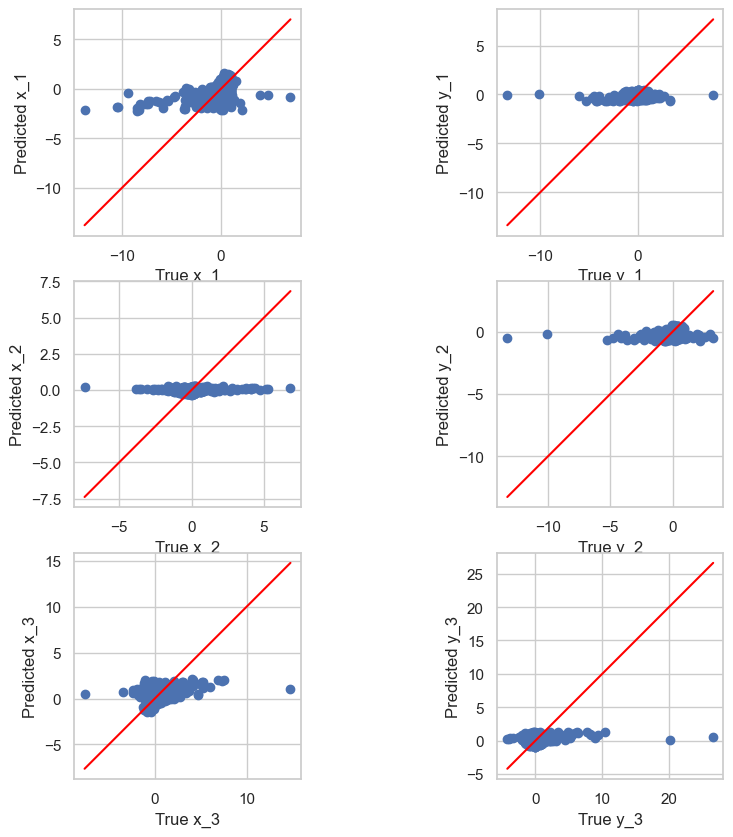

In [593]:
#Prends des points randoms si >500 points
plot_y_yhat(y_val.values, y_pred_val, plot_title="plot")

CREATE SUBMISSION CSV

In [523]:
X_test = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
X_test.columns = ['t','x_1','y_1','x_2','y_2','x_3','y_3']  # correspond aux input_cols du fit
ids = test['Id']

# Faire les prédictions
predictions = pipeline.predict(X_test)

# Créer le CSV de sortie
target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
output_df = pd.DataFrame(predictions, columns=target_cols)
output_df.insert(0, 'Id', ids)
output_df.to_csv('baseline-model.csv', index=False)
